In [1]:
from pyspark.sql import SparkSession
import numpy as np
import string
spark = SparkSession.builder.appName('topic_models').config("spark.local.dir", "/scratch/midway2/cloptla").getOrCreate()

# load the data
data = spark.read.format("CSV").option("header","true").csv("/project/cmsc25025/stackexchange/20161215StatsPostsMerged.csv")
rdd = data.rdd.map(lambda row: str(row).lower().encode('utf-8').translate(None, string.punctuation))


In [2]:
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist

# create a vocabulary of ~10,000 words
counts = rdd.map(lambda x: FreqDist(word for word in word_tokenize(x)))
total_counts = counts.reduce(lambda a,b: a + b)

In [3]:
top70 = total_counts.most_common(70)
top70words = [x[0] for x in top70]
vocab = [k for k, v in total_counts.items() if v > 30 and k not in top70words and len(k) > 3] # remove most and least common words
print len(vocab)

10069


We use nltk to compute the FreqDist of words for the StatsPostsMerged.csv file. We remove the 70 most common words, all words of length less than or equal to 3, and all words that occurs less than or equal to 30 times (the least frequent words).

In [5]:
from pyspark.ml.linalg import Vectors

def format(FD):
    vocab_counts = [0]*len(vocab)
    for k,v in FD.items():
        if k in vocab:
            vocab_counts[vocab.index(k)] = v
    return Vectors.dense(vocab_counts)

corpus = counts.map(lambda FD: format(FD)).zipWithIndex().map(lambda x: [x[1], x[0]])

In [6]:
# divide into training and validation sets (90%/10%)
train,validate = corpus.randomSplit([9.0, 1.0], 123)

In [7]:
from pyspark.ml.clustering import LDA, LDAModel

def printtopics(x): 
    for i,val in enumerate(x): 
        x[i] = vocab[val]
    return x

ntopics = [10, 30, 50] # number of topics

for n in ntopics:

    print "%d topics" % n
    
    # train the model
    lda = LDA(k=n, seed=4, optimizer ="em", maxIter=40)
    ldaModel = lda.fit(train.toDF(['id' , 'features']))

    # display top 10 words in each topic
    topicIndices = ldaModel.describeTopics(maxTermsPerTopic = 10)
    topics = topicIndices.rdd.map(lambda x: [x['topic'] , printtopics(x['termIndices'])])
    topics.toDF(['topic', 'words']).show(topics.count(), truncate=False)

10 topics
+-----+--------------------------------------------------------------------------------------------------+
|topic|words                                                                                             |
+-----+--------------------------------------------------------------------------------------------------+
|0    |[series, probability, process, state, random, year, given, forecast, event, poisson]              |
|1    |[standard, normal, confidence, population, size, interval, hypothesis, variance, group, groups]   |
|2    |[probability, number, than, first, other, question, same, times, people, want]                    |
|3    |[matrix, function, correlation, variance, distance, covariance, density, gaussian, random, vector]|
|4    |[learning, algorithm, function, training, problem, features, output, network, input, feature]     |
|5    |[models, parameters, linear, error, function, parameter, also, used, want, here]                  |
|6    |[want, question, the

For 10 topics: topic 1 clearly has to do with statistical tests/measures, topic 4 has terms related to neural networks, topic 8 concerns various measurements of analysis, and topic 9 pertains to measurements related to performance. 

For 30 topics we see more variety. Topic 10 deals with clustering, topic 15 and 28 both have common statistical terms, and topic 29 still relates to neural networks. Some topics seem more sensible than others. 

For 50 topics, topic 6 again has common statistical terms, topic 1 has to do with bayesian inference and markov chains, topic 18 concerns classification terms. With the increased topic size, some topics have become less meaningful and have more general terms.

In [16]:
sample_transformed = ldaModel.transform(corpus.toDF(['id' , 'features'])).take(10)
sample_text = rdd.take(10)

for x in range(10):
    
    print "Document %d:" % x
    
    # print some of the text
    print sample_text[x][18:500]
    
    # find the topics
    topics =  sample_transformed[x]['topicDistribution']
    topics = np.array(topics).argsort()[::-1][:5]
    print "Top five topics:" 
    print topics 

Document 0:
eliciting priors from experts how should i elicit prior distributions from experts when fitting a bayesian model john cook gives some interesting recommendations basically get percentilesquantiles not means or obscure scale parameters from the experts and fit them with the appropriate distribution    eliciting priors is a tricky business   statistical methods for eliciting probability distributions and eliciting probability distributions are quite good practical guides for prio
Top five topics:
[35 21  1 12 13]
Document 1:
what is normality in many different statistical methods there is an assumption of normality  what is normality and how do i know if there is normality the assumption of normality assumes your data is normally distributed the bell curve
Top five topics:
[10  6 21 37 31]
Document 2:
what are some valuable statistical analysis open source projects what are some valuable statistical analysis open source projects available right now  edit as pointed out by sha

Above we have the first 500 characters of the document with the top 5 most probable topics. The assigned topics do make sense. Note that the most probable topics above were generated with the model with 50 topics. As the topic size increased, topics became more nuanced, having a couple of common terms but then some more general terms that may just appear near those terms. I would say k = 30 generated the most meaningful topics.

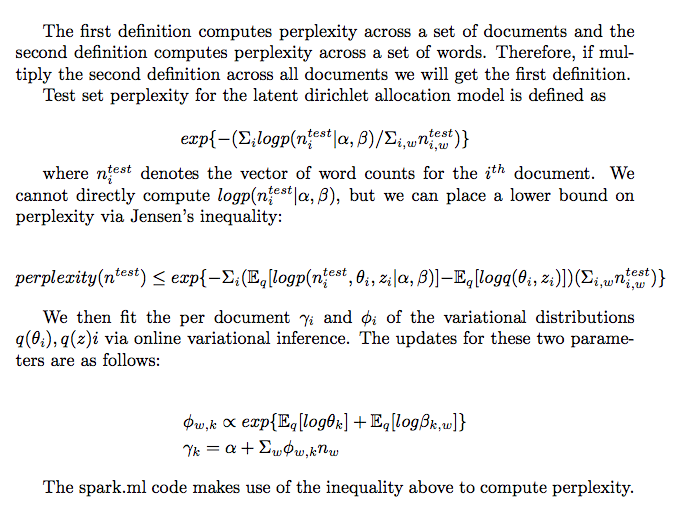

In [10]:
from IPython.display import Image 
Image(filename='2C.png')

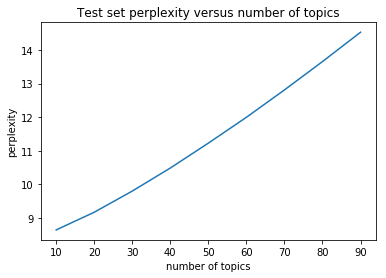

In [13]:
import matplotlib.pyplot
from pyspark.ml.clustering import LDA, LDAModel

# evaluate test perplexity for a range of models
ntopics = range(10,100,10)
perplexity = [0]*len(ntopics)

for i,n in enumerate(ntopics):
    
    # compute the perplexity of the test set (validate)
    lda = LDA(k=n, seed=4, optimizer="online", maxIter=10)
    ldaModel = lda.fit(train.toDF(['id' , 'features']))
    perplexity[i] = ldaModel.logPerplexity(validate.toDF(['id' , 'features']))
    print perplexity[i]

plt.figure()
plt.plot(ntopics,perplexity)
plt.xlabel('number of topics')
plt.ylabel('perplexity')
plt.title('Test set perplexity versus number of topics')
plt.show()

In [21]:
# show some topics from the set with largest k
lda = LDA(k=150, seed=4, optimizer ="em", maxIter=40)
ldaModel = lda.fit(train.toDF(['id' , 'features']))
topicIndices = ldaModel.describeTopics(maxTermsPerTopic = 10)
topics = topicIndices.rdd.map(lambda x: [x['topic'] , printtopics(x['termIndices'])])
topics.toDF(['topic', 'words']).show(10, truncate=False)

+-----+---------------------------------------------------------------------------------------------------------+
|topic|words                                                                                                    |
+-----+---------------------------------------------------------------------------------------------------------+
|0    |[analysis, other, want, these, same, they, question, also, could, correlation]                           |
|1    |[standard, normal, value, variance, function, random, estimate, question, know, given]                   |
|2    |[function, problem, example, want, question, also, know, find, here, only]                               |
|3    |[question, value, know, random, example, want, same, here, just, given]                                  |
|4    |[tests, groups, multiple, comparisons, correction, significant, comparison, pairwise, differences, genes]|
|5    |[function, curve, spline, points, splines, problem, example, cubic, find, want]  

We found that perplexity monotonically increases as the number of topics increases; therefore, the best model appears to be the one with only 10 topics. This makes sense as since we are only looking at statistics/machine learning questions, there is probably a limited number of meaningful topics in these posts which likely lies in the range of 10-30. As shown above, a model in which k = 150, the topics become less meaningful as the vocabulary is being spread too thin to generate distinct topics. We expected there to be a dip in perplexity followed by a continuous increase. We may not have observed this because logPerplexity computes the upper bound on perplexity rather than an accurate one. 